

---


# Sign Language Recognition - Final Project
**Author: Thomas Dalrymple**


> The aspects of this project
1. Creating a data set
2. Training a CNN and getting a benchmark accuracy
3. Training an improved CNN model and getting a resulting accuracy
4. Comparing the accuracies of the two models





---



# Imports


---



In [3]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import itertools
import random
import warnings
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Create the Gesture Data**


---

> Creates the train data and test data.

Code obtained from:
Sign language recognition using python and opencv. DataFlair. (2021, August 25). Retrieved March 3, 2022, from https://data-flair.training/blogs/sign-language-recognition-python-ml-opencv/ 



In [ ]:
background = None
accumulated_weight = 0.5

ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350


def cal_accum_avg(frame, accumulated_weight):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    cv2.accumulateWeighted(frame, background, accumulated_weight)


def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)

    _ , thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)

    # Grab the external contours for the image
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None
    else:
        
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        return (thresholded, hand_segment_max_cont)


cam = cv2.VideoCapture(0)

num_frames = 0
element = 10
num_imgs_taken = 0

while True:
    ret, frame = cam.read()

    # filpping the frame to prevent inverted image of captured frame...
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    if num_frames < 60:
        cal_accum_avg(gray_frame, accumulated_weight)
        if num_frames <= 59:
            
            cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
         
    #Time to configure the hand specifically into the ROI...
    elif num_frames <= 300: 

        hand = segment_hand(gray_frame)
        
        cv2.putText(frame_copy, "Adjust hand...Gesture for" + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        
        # Checking if hand is actually detected by counting number of contours detected...
        if hand is not None:
            
            thresholded, hand_segment = hand

            # Draw contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames)+"For" + str(element), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

            # Also display the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
    
    else: 
        
        # Segmenting the hand region...
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            # unpack the thresholded img and the max_contour...
            thresholded, hand_segment = hand

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            cv2.putText(frame_copy, str(num_imgs_taken) + 'images' +"For" + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            # Displaying the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
            if num_imgs_taken <= 300:
                # insert path for images
                cv2.imwrite(r"C:\\Users\\" + str(num_imgs_taken) + '.jpg', thresholded)
            else:
                break
            num_imgs_taken +=1
        else:
            cv2.putText(frame_copy, 'No hand detected...', (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    # Drawing ROI on frame copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right, ROI_bottom), (255,128,0), 3)
    
    cv2.putText(frame_copy, "DataFlair hand sign recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    
    # increment the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.imshow("Sign Detection", frame_copy)

    # Closing windows with Esc key...(any other key with ord can be used too.)
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Releasing camera & destroying all the windows...

cv2.destroyAllWindows()
cam.release()

# Load Data Set


---
> Obtain the data set from google drive and plot the images.






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3010 images belonging to 10 classes.
Found 210 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

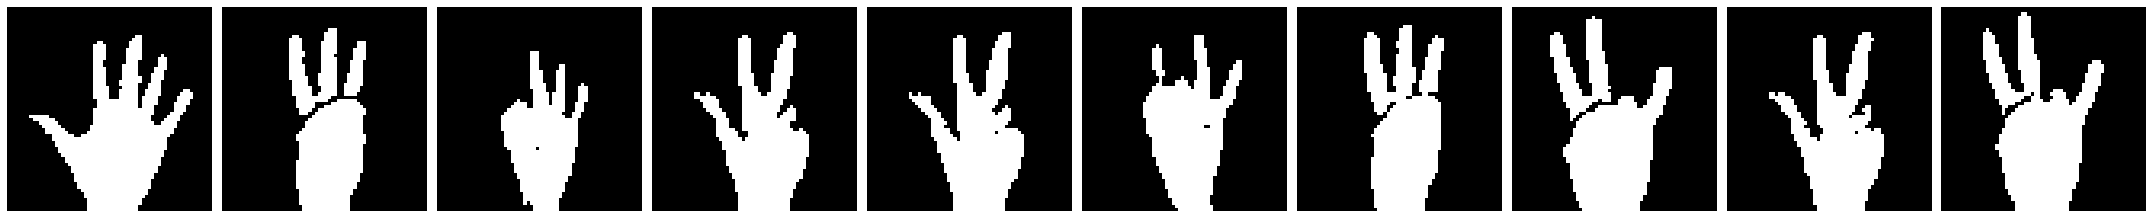

shape (10, 64, 64, 3)
labels [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [5]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

train_path = '/content/drive/My Drive/Colab Notebooks/' # insert correct path to train images
test_path = '/content/drive/My Drive/Colab Notebooks/' # insert correct path to test images

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=10,shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)

# imgs, labels = next(train_batches)
train_imgs, train_labels = next(train_batches)
test_imgs, test_labels = next(train_batches)

#Plotting the images...
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(train_imgs)
print('shape', train_imgs.shape)
print('labels', train_labels)

# Train the CNN model


---





In [6]:
model = Sequential()

model.add(Conv2D(32, (5, 5), padding='same',input_shape=train_imgs.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=(2, 2)))

# flatten to make the output 2D
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

# Output layer
model.add(Dense(10))
model.add(Activation('softmax'))

opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                        

# Test the CNN model

---


> This will be treated as the benchmark accuracy.






Epoch 1/10
301/301 [==============================] - 143s 476ms/step - loss: 3.9604e-11 - accuracy: 1.0000 - val_loss: 109.9483 - val_accuracy: 0.4048
Epoch 2/10
301/301 [==============================] - 76s 251ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 109.9544 - val_accuracy: 0.4048
Epoch 3/10
301/301 [==============================] - 75s 249ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 109.9597 - val_accuracy: 0.4048
Epoch 4/10
301/301 [==============================] - 74s 246ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 109.9643 - val_accuracy: 0.4048
Epoch 5/10
301/301 [==============================] - 75s 250ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 109.9685 - val_accuracy: 0.4048
Epoch 6/10
301/301 [==============================] - 76s 252ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 109.9723 - val_accuracy: 0.4048
Epoch 7/10
301/301 [==============================] - 82s 273ms/step - loss: 0.0000e+00 - acc

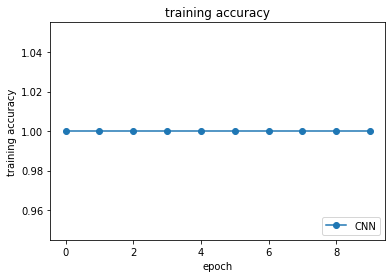

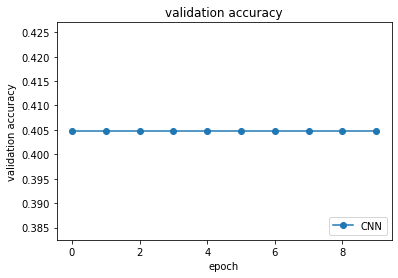

Test accuracy for CNN: 0.4047619104385376


In [8]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data = test_batches)

# Plot training accuracy
plt.plot(history.history['accuracy'], 'o-', label='CNN')
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'], 'o-', label='CNN')
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

print('Test accuracy for CNN: {}'.format(history.history['val_accuracy'][9]))

# Improved CNN Model


---



In [9]:
model = Sequential()

# first stack
model.add(Conv2D(32, (3, 3), padding='same',input_shape=train_imgs.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

# second stack
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# third stack
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# fourth stack
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten to make the output 2D
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(10))
model.add(Activation('softmax'))

opt = 'Adam'

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 activation_3 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_4 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                      

# Test Improved CNN Model


---



Epoch 1/10
301/301 [==============================] - 92s 301ms/step - loss: 1.4774 - accuracy: 0.5429 - val_loss: 1.2715 - val_accuracy: 0.6714
Epoch 2/10
301/301 [==============================] - 84s 278ms/step - loss: 0.0718 - accuracy: 0.9764 - val_loss: 2.9532 - val_accuracy: 0.7000
Epoch 3/10
301/301 [==============================] - 85s 282ms/step - loss: 0.0531 - accuracy: 0.9837 - val_loss: 2.6142 - val_accuracy: 0.5286
Epoch 4/10
301/301 [==============================] - 90s 298ms/step - loss: 0.0696 - accuracy: 0.9847 - val_loss: 1.8265 - val_accuracy: 0.7143
Epoch 5/10
301/301 [==============================] - 87s 289ms/step - loss: 0.0268 - accuracy: 0.9927 - val_loss: 2.8699 - val_accuracy: 0.5238
Epoch 6/10
301/301 [==============================] - 93s 309ms/step - loss: 0.0162 - accuracy: 0.9957 - val_loss: 4.1860 - val_accuracy: 0.7000
Epoch 7/10
301/301 [==============================] - 84s 280ms/step - loss: 0.0536 - accuracy: 0.9864 - val_loss: 4.3443 - val_ac

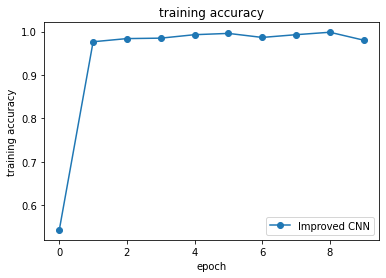

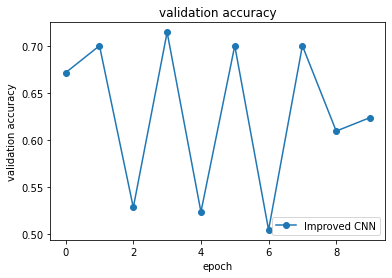

Test accuracy for improved CNN: 0.6238095164299011


In [10]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data = test_batches)

# Plot training accuracy
plt.plot(history.history['accuracy'], 'o-', label='Improved CNN')
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'], 'o-', label='Improved CNN')
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

print('Test accuracy for improved CNN: {}'.format(history.history['val_accuracy'][9]))